In [1]:
import brainspace            #for plotting and calculating gradients
import numpy as np           #for working with arrays
import pandas as pd          #for working with data frames
import nilearn               #for plotting matrices
import seaborn               #for scatter and density plots
import brainstat
import scipy

In [2]:
from brainspace.datasets import load_conte69, load_parcellation, load_fsa5
from nilearn.datasets import fetch_atlas_schaefer_2018
from brainspace.utils.parcellation import map_to_labels
from brainspace.plotting import plot_hemispheres
from nilearn.connectome import ConnectivityMeasure
import nilearn.plotting
from brainspace.gradient import GradientMaps
import matplotlib.pyplot as plt
from brainstat.datasets import fetch_parcellation, fetch_template_surface
from scipy.io import loadmat

In [3]:
path= '/data/p_02667/Liisbeth/data/fc_matrices_glasser/Mean/'    # collecting the path, where all the matrices are saved

In [4]:
# Code written by Bianca Serio

import os

def fetch_all_sub_conn_matrices(path_conn_matrices):
    
    '''|
    
    Function that fetches the connectivity matrices of all subjects from path and stores them in a variable 
    
    Input:
    - path containing all the subject connectivity matrices
    
    Output (dictionary containing):
    - conn_matrices: np array contianing the connectivty matrices of all subjects (in the form of 1 np array per subject)
    - sub_list: list containing all the subject IDs
    
    
    '''
    
    # list that contains all the subject IDs of subjects with fc matrices
    sub_list = []

    # list that contains the fc matrices of all subjects in the form of 1 np array per subject
    conn_matrices = []

    # reads (lists) the content of the path containing the list of fc_matrices and stores the sorted contents in as a list in the variable list_fc_matrices
    list_conn_matrices = os.listdir(path_conn_matrices)
    list_conn_matrices.sort()

    for e in list_conn_matrices:
        if '.csv' in e:  # need to do this because there is a hidden files in the path_list_fc_matrices

            # add subject to the subjects' list
            sub_list.append(e.partition(".")[0])  # this partitions the subID.csv into a 3-tuple containing ('subID', '.', 'csv'), and I keep only the subID

            # reads csv file in the form of an array
            sub_matrix = np.genfromtxt(path_conn_matrices + e, delimiter=',')

            # add subject's matrix to the fc_matrices_400 list
            conn_matrices.append(sub_matrix)

    print(f'Connectivity matrices found in path {path_conn_matrices}: N = {len(sub_list)}')
    
    dict_output = {'conn_matrices': conn_matrices, 'sub_list': sub_list}
    
    return dict_output

In [5]:
# Code written by Bianca Serio

# fetch the functional connectivity matrices of all subjects (1014 subjects)
HCP_all = fetch_all_sub_conn_matrices(path)

# store the functional connectivity matrices and subject list in respecive variables
HCP_fc_matrices = HCP_all['conn_matrices']
HCP_sub_list = HCP_all['sub_list']


Connectivity matrices found in path /data/p_02667/Liisbeth/data/fc_matrices_glasser/Mean/: N = 1007


In [6]:
# Everything is included in brainspace

labeling= fetch_parcellation('fsaverage5', 'glasser', 360, data_dir = '/data/p_02667/Liisbeth/anaconda3/envs/actualdata/Glasser/')   # Importing the Schaefer 400 parcellation (for 64984 surf points)
atlas=  pd.read_csv('/data/p_02667/Liisbeth/anaconda3/envs/actualdata/Glasser/glasser360-master/glasser360NodeNames.txt', header =None)                 # Importing the labels/mapping of the parcellation
surf_lh, surf_rh=fetch_template_surface('fsaverage5', join = False, data_dir ='/data/p_02667/Liisbeth/anaconda3/envs/actualdata/Glasser/')                                # Loading the hemisphere surfaces with 32492 surf points per hemisphere
atlas = np.asarray(atlas)

In [7]:
mean_matrix = sum(HCP_fc_matrices)/len(HCP_fc_matrices)

In [ ]:
nilearn.plotting.plot_matrix(mean_matrix, figure=(30,30),labels = atlas, reorder=True)

In [8]:
gm_mean = GradientMaps(n_components=10, approach='dm', random_state=0, kernel = 'normalized_angle')  # creating the gradient model
# random state = 0 for replicable results

gm_mean.fit(mean_matrix)  # Fitting the gradient model to the mean connectivity matrix

GradientMaps(kernel='normalized_angle', random_state=0)

In [9]:
## Plotting the first 3 gradients

mask = labeling != 0     # Creating a boolean mask

grad_mean = [None]*3     # Creating an empty list for 3 gradients

for i in range(3):
    grad_mean[i]=map_to_labels(gm_mean.gradients_[:,i], labeling, mask = mask, fill=np.nan)  # Mapping gradient loadings to the parcellation
    


In [11]:
# Plotting the first 3 gradients and saving the image

plot = plot_hemispheres(surf_lh, surf_rh, 
                                array_name=grad_mean, 
                                embed_nb = True, 
                                size=(1200, 400), 
                                cmap='viridis_r', 
                                color_bar=True, 
                                label_text=['Gradient 1', 'Gradient 2', 'Gradient 3'], 
                                zoom=1.55,
                                screenshot = True,
                                filename = 'HCP_fcGlasser_DM_plotted_hemispheres_mean_gradients.png')

In [129]:
yeo_networks_glasser = scipy.io.loadmat( 'yeo_glasser360.mat' )
networks_yeo_numpy_df = pd.DataFrame(yeo_networks_glasser['yeo_glasser'])
networks_yeo_numpy_df = networks_yeo_numpy_df.replace(0,np.nan)
                                                   

networks_yeo_numpy = pd.DataFrame.to_numpy(networks_yeo_numpy_df.T)


np.argwhere(np.isnan(networks_yeo_numpy[0]))

array([[109],
       [119],
       [289],
       [299]])

In [131]:
index = [109, 119, 289, 299]
gm_mean1_adjusted = np.delete(gm_mean.gradients_[:,0], index)
gm_mean2_adjusted = np.delete(gm_mean.gradients_[:,1], index)
networks_yeo_numpy = networks_yeo_numpy[0][~np.isnan(networks_yeo_numpy[0])]

In [144]:
networks_yeo_numpy[0]

1.0

In [118]:
gm_mean.gradients_[:, 0]

-0.08754674522467058

In [134]:
yeo7_networks_array_labels = []

for i in networks_yeo_numpy.T:
    if i == 1:
        yeo7_networks_array_labels.append('visual')
    elif i == 2:
        yeo7_networks_array_labels.append('sensory motor')
    elif i == 3:
        yeo7_networks_array_labels.append('dorsal attention')
    elif i == 4:
        yeo7_networks_array_labels.append('ventral attention')
    elif i == 5:
        yeo7_networks_array_labels.append('limbic')
    elif i == 6:
        yeo7_networks_array_labels.append('fronto parietal')
    elif i == 7:
        yeo7_networks_array_labels.append('DMN')

        
yeo7_networks_array_labels = np.asarray(yeo7_networks_array_labels)

network_names = ["visual", "sensory motor", "dorsal attention", "ventral attention", "limbic", "fronto parietal", "DMN"]

In [136]:
len(yeo7_networks_array_labels)

356

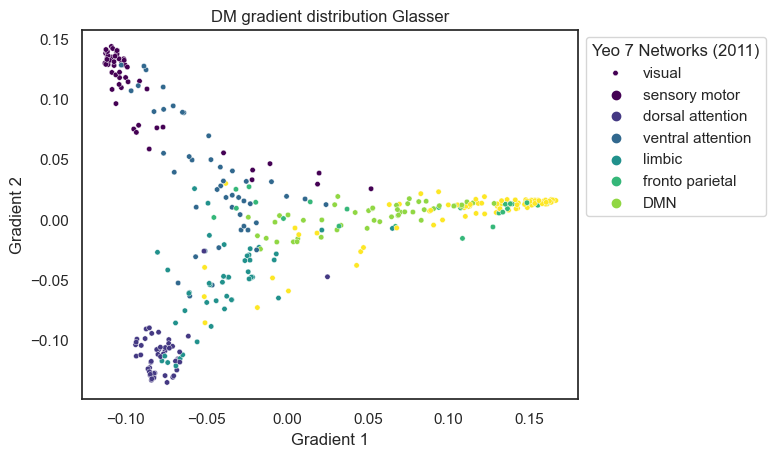

In [145]:


seaborn.set_theme(style='white')
cmap = 'viridis_r'
xlim=(-0.17,0.17)
ylim=(-0.17,0.17)
h=seaborn.scatterplot(x=gm_mean1_adjusted, y=gm_mean2_adjusted, hue = networks_yeo_numpy,
                    palette = "viridis", s=15)

plt.title('DM gradient distribution Glasser')
plt.xlabel('Gradient 1')
plt.ylabel('Gradient 2')
#h.set_axis_labels('Gradient1', 'Gradient2', fontsize=16)

#h.fig.suptitle("PCA gradient distribution", y=1)

fig = h.get_figure()
fig.savefig('/data/p_02667/Liisbeth/anaconda3/envs/actualdata/Glasser/DM_gradient_distributionGlasser.png') 
plt.legend(title="Yeo 7 Networks (2011)", labels=['visual',"sensory motor", "dorsal attention", "ventral attention", "limbic", "fronto parietal", "DMN"] , bbox_to_anchor=(1, 1))


In [13]:
loadings = []*1007      # Creating an empty list, where the loadings for the first gradient for each participant will be appended

for i in range(len(HCP_fc_matrices)):
    gm = GradientMaps(approach = 'dm', random_state=0, kernel='normalized_angle', alignment='procrustes') #creating the alignment model
    gm.fit(HCP_fc_matrices[i], reference = gm_mean.gradients_) # fitting the alignment gradient model to each participants 400x400 connectivity matrix
    loadings.append(gm.aligned_[:,0]) #appending the loadings (1st gradient) for each parcel and each participant to the loadings list

In [ ]:
loadings_df_Glasser=pd.DataFrame(loadings) # converting the loadings list to a pandas dataframe
    
loadings_df_Glasser.to_csv('G1_loadings_Glasser.csv', index=False) # saving the df as a csv file for further analyses in R

In [165]:
sextq_values_DM = pd.read_csv('/data/p_02667/Liisbeth/anaconda3/envs/actualdata/Glasser/sex_contrasts_DM.csv', sep = ';', decimal=',')

sextq_values_DM_adj = sextq_values_DM.drop(axis = 0, index = index)
sextq_values_DM_adj.index = range(len(sextq_values_DM_adj))
sextq_numpy_DM = sextq_values_DM.to_numpy() # Converting the data frame to a numpy array

t_value_DM = sextq_values_DM['t_value'].to_numpy()  #extracting the t values as a numpy array
q_value_DM = sextq_values_DM['q_val'].to_numpy()    #extracting the q values (FDR corrected p values) as a numpy array

In [29]:
significant_parcels = []*360   # creating an empty list for 360 t values

for i in range(len(sextq_numpy_DM)):
    
    if sextq_numpy_DM[i, 2] < 0.05:     # if the corrected p-value (q-value) is <0.05 then...
              significant_parcels.append(sextq_numpy_DM[i, 0]) #t-value will be appended to the list.
    else:                                            # OTHERWISE
        significant_parcels.append(float('nan'))     # NaN will be appended
        
significant_parcels = np.array(significant_parcels)  # Converting the list to a numpy array
                                                     

In [157]:

sextq_numpy_DM_adj = np.delete(sextq_numpy_DM, index, axis = 0)

significant_parcels_adj = []*360   # creating an empty list for 360 t values

for i in range(len(sextq_numpy_DM_adj)):
    
    if sextq_numpy_DM_adj[i, 2] < 0.05:     # if the corrected p-value (q-value) is <0.05 then...
              significant_parcels_adj.append(sextq_numpy_DM_adj[i, 0]) #t-value will be appended to the list.
    else:                                            # OTHERWISE
        significant_parcels_adj.append(float('nan'))     # NaN will be appended
        
significant_parcels_adj = np.array(significant_parcels_adj)  # Converting the list to a numpy array
                                                     

In [158]:
sextq_numpy_DM_adj.shape

(356, 3)

In [30]:
mapped_significant = map_to_labels(significant_parcels, labeling, mask = mask, fill = np.nan) # mapping the t-values to the surface points

In [17]:
fdr_corr_tvals_plotted_hemispheres = plot_hemispheres(
        surf_lh, 
        surf_rh, 
        array_name = mapped_significant, 
        embed_nb = True, 
        size = (1400,200), 
        cmap = "bwr_r",  # bwr, _r stands for reversed; using it to match male-blue female-red 
        color_bar = True, 
        #color_range = color_range_t,
        nan_color = (0.7, 0.7, 0.7, 1),
        label_text = ["t-values"],
        zoom = 1.45,
        screenshot = True,
        filename = 'HCP_fcGlasser_DM_plotted_hemispheres_sex_contrast_t_val_fdr_corr.png')

In [18]:
fdr_corr_tvals_grad1 = plot_hemispheres(
        surf_lh, 
        surf_rh, 
        array_name = [grad_mean[0],mapped_significant], 
        embed_nb = True, 
        size = (1400,200), 
        cmap = ['viridis_r', "bwr_r"],  # bwr, _r stands for reversed; using it to match male-blue female-red 
        color_bar = True, 
        #color_range = color_range_t,
        nan_color = (0.7, 0.7, 0.7, 1),
        label_text = ['Mean gradient', "t-values"],
        zoom = 1.45,
        screenshot = True,
        filename = 'HCP_fcGlasser_DM_plotted_hemispheres_sex_contrast_t_val_fdr_gradient1.png')

In [159]:
def regression_contrast_results_breakdown_by_network(reg_res, contrast_type, scatterplot = True, scatter_x = None, scatter_y = None, scatter_x_label = None, 
                                                     scatter_y_label = None, sample_modality = None):
    
    '''
    
    Function that outputs the breakdown of regression contrast results by network
    
    Input:
    - reg_res: regression results (in fomrat: DataFrame, containing columns 'q_val_sel' and 't_val_sex', len = 400 parcels (Schaeffer400))
    - contrast type: string indicating the contrast that is being studied, e.g., 'sex' (for plot titles)
    - scatter_x: x-axis of the scatterplot G1 vs G2 -> so G1 or G2 from mean gradient (in array format)
    - scatter_y: y-axis of the scatterplot G1 vs G2 -> so G1 or G2 from mean gradient (in array format)
    - scatter_x_label, scatter_y_label
    - sample_modality: string, e.g. GSP_local_ct or HCP_fc_G1 (for name of figures saved in resdir_fig)
    
    Output (display):
    - written breakdown (number and proportion of significant parcels by network (relative proportion (i.e., out of all the parcels belonging to a given network) and absolute proportion (i.e., out of the total significant results)
    - plotted breakdown (pie chart) - proportion of significant parcels by network (absolute proportion)
    - plotted breakdown by sex (nested pie chart) - proportion of significant parcels by network (absolute proportion) by sex <- !!! HARDCODED M vs F labels !!! - color coding with original Yeo network colors
    - plotted breadown by sex (nested pie chart) - same as above, WITHOUT LABELS
    - Violin plot of t-values (regression results) by Yeo network
    - scatter plot showing of G1 vs G2, displaying parcels showing a significant contrast in dark
    
    '''
    
    ### written breakdown
    
    # counting number of significant parcels
    # storing the Q values in a list (where non significant Q values are marked as 1 -> for later potential scatterplot visualization)
    # making a dictionary that counts the number of significant parcels per yeo network
    # making dictionaries that count the number of significant parcels per yeo network by sex
    


    
    sig_Q_vals_slm = []
    count_sig = 0
    count_sig_M = 0
    count_sig_F = 0
    count_sig_per_network = {"visual": 0, "sensory motor": 0, "DMN": 0, "dorsal attention": 0, "ventral attention": 0, "limbic": 0, "fronto parietal": 0}
    count_sig_per_network_bysex = {"visual": [0, 0], "sensory motor": [0,0], "DMN": [0,0], "dorsal attention": [0,0], "ventral attention": [0,0], "limbic": [0,0], "fronto parietal": [0,0]} # M: [0], F: [1]
    
    for i in range(len(reg_res.q_val)):
    
        if reg_res.q_val[i] < 0.05:
            count_sig += 1
            count_sig_per_network[yeo7_networks_array_labels[i]] += 1
            sig_Q_vals_slm.append(1)
    
            # positive t-values mean male > female: increment the first item of the list fort given label
            if reg_res.t_value[i] > 0:
                count_sig_M += 1
                count_sig_per_network_bysex[yeo7_networks_array_labels[i]][0] += 1
            
            # positive t-values mean female > male: increment the second item of the list for the given label
            else:
                count_sig_F += 1
                count_sig_per_network_bysex[yeo7_networks_array_labels[i]][1] += 1
        
        else:
            sig_Q_vals_slm.append(0)
    
    print(f"Number of significant parcels: {count_sig}\n")
    print(f"Number of significant parcels for males: {count_sig_M}")
    print(f"Number of significant parcels for females: {count_sig_F}\n")
    print("Number of significant parcels in each Yeo network (across sexes):")
    
    # using ANSI escape sequences to underline -> bold: \033[1m ; underline: \033[4m ; end: \033[0m
    for i in range(len(count_sig_per_network)):
        print(f"- {list(count_sig_per_network.keys())[i]}: \033[4m{count_sig_per_network[list(count_sig_per_network.keys())[i]]}\033[0m out of {yeo7_networks_array_labels.tolist().count(network_names[i])} ({round(count_sig_per_network[list(count_sig_per_network.keys())[i]] / yeo7_networks_array_labels.tolist().count(network_names[i]) * 100, 2)}%) -> \033[1m{round(count_sig_per_network[list(count_sig_per_network.keys())[i]]*100/count_sig,2)}%\033[0m of overall significance")
    
    print("\n\n")
    
    
    
    
    ### Pie chart breakdown per network
    
    # setting figure size
    fig, ax = plt.subplots(1, figsize=(10, 7))
    
    # data to plot: in dictionary count_sig_per_network
    network_labels = []
    data = []
    
    for x, y in count_sig_per_network.items():
        network_labels.append(x)
        data.append(y)
    
    # define color palette to use
    color_palette =[(227/255, 174/255, 211/255),  # color palette matching the raincloudplot colors (rgb found via mac's digital color meter, then /255 to obtain 0-1 values as required by plt
                    (185/255, 163/255, 204/255),
                    (120/255, 162/255, 189/255),
                    (236/255, 170/255, 119/255),
                    (174/255, 147/255, 143/255),
                    (216/255, 128/255, 129/255),
                    (128/255, 183/255, 126/255)]
    
    # plot pie chart
    ax.pie(data,
           labels = network_labels, colors = color_palette, autopct='%.0f%%',
           wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
           textprops={'fontsize': 20})
    
    ax.set_title(f'Breakdown of parcels by network showing a statistically significant {contrast_type} difference in gradient loadings', y=1.03, fontsize=20)
    
    # display
    ax.axis('equal')
    plt.tight_layout()
    
    
    
    ### Nested pie chart
    
    ## make data plottable
    list_count_sig_per_network_bysex = []
    
    for label in count_sig_per_network_bysex:
        list_count_sig_per_network_bysex.append(count_sig_per_network_bysex[label])
    
    vals = np.array(list_count_sig_per_network_bysex)
    
    outer_colors = ["darkorchid",  # visual
                    "steelblue",  # sensorimotor
                    "indianred",  # dmn
                    "forestgreen",  # dorsal attention
                    "orchid",  # ventral attention
                    "lemonchiffon",  # limbic
                    "orange"]  # frontoparietal
    inner_colors = ['lightblue', 'lightcoral',  # visual
                    'lightblue', 'lightcoral',  # sensorimotor
                    'lightblue', 'lightcoral',  # dmn
                    'lightblue', 'lightcoral',  # dorsal attention
                    'lightblue', 'lightcoral',  # ventral attention
                    'lightblue', 'lightcoral',  # limbic
                    'lightblue', 'lightcoral']  #frontoparietal
    
    fig, ax = plt.subplots(figsize=(15, 10))
    
    size = 0.3
    
    ## plot outer pie
    ax.pie(vals.sum(axis=1), radius=1, labels=count_sig_per_network_bysex.keys(), colors=outer_colors, autopct='%.0f%%', pctdistance=0.85,
           wedgeprops=dict(width=size, edgecolor='white'),  textprops={'fontsize': 20})
    
    ## plot inner pie
    
    # make a list (in order) containing the labels (sex - hardcoded) only for sections that have more than 1 count (otherwise label is placeholder: blank)
    
    labels_only_show_non_null = []
    
    for network in list_count_sig_per_network_bysex:
    
        # males
        if network[0] > 0:
            labels_only_show_non_null.append('M')
        else:
            labels_only_show_non_null.append('')
        
        # females
        if network[1] > 0:
            labels_only_show_non_null.append('F')
        else:
            labels_only_show_non_null.append('')
    
    ax.pie(vals.flatten(), radius=1-size, labels=labels_only_show_non_null, colors=inner_colors,
           wedgeprops=dict(width=size, edgecolor='white'),  textprops={'fontsize': 15},  labeldistance=0.78)
    
    ax.set(aspect="equal")
    ax.set_title(f'Breakdown of parcels by network showing a statistically significant {contrast_type} difference in gradient loadings, by {contrast_type}', y=1.03, fontsize=20)
    
    plt.show()
    
    print('Number of significant parcels by sex:')
    for network in count_sig_per_network_bysex:
        print(f"{network} - Male: {count_sig_per_network_bysex[network][0]}, Female: {count_sig_per_network_bysex[network][1]}")
    
    print("\n\n")
    
    
    
    ### plot outer and inner pie (without labels)
    
    fig, disp = plt.subplots(figsize=(15, 10))
    size = 0.3
    
    disp.pie(vals.sum(axis=1), radius=1, colors=outer_colors, pctdistance=0.85,
           wedgeprops=dict(width=size, edgecolor='black'),  textprops={'fontsize': 20})
    
    disp.pie(vals.flatten(), radius=1-size, colors=inner_colors,
           wedgeprops=dict(width=size, edgecolor='blacK'),  textprops={'fontsize': 15},  labeldistance=0.78)
    
    disp.set(aspect="equal")
    
    plt.show()
    
    
    ## save figure in directory 
    fig.savefig('/data/p_02667/Liisbeth/anaconda3/envs/actualdata/Glasser/'+sample_modality+'_pie_chart_sex_diff_netw.png', dpi=300)
    
    print("\n\n")
    
    
    
    ### Violin plot of t-values (regression results) by Yeo network
    
    print("Violin plot of t-values (regression results) by Yeo network")
    
    df_to_plot = pd.DataFrame(reg_res.t_value)
    
    df_to_plot['yeo network'] = yeo7_networks_array_labels
    
    # color palette matching the raincloudplot colors (rgb found via mac's digital color meter, then /255 to obtain 0-1 values as required by plt
    color_palette =[(227/255, 174/255, 211/255),  # visual
                    (185/255, 163/255, 204/255),  # sensory motor
                    (236/255, 170/255, 119/255),  # dorsal attention
                    (174/255, 147/255, 143/255),  # ventral attention
                    (216/255, 128/255, 129/255),  # limbic
                    (128/255, 183/255, 126/255),  # fronto parietal
                    (120/255, 162/255, 189/255)]  # DMN
    
    fig, ax = plt.subplots(figsize = (15,5));
    
    ax = seaborn.violinplot(data=df_to_plot,
                        x="yeo network",
                        y="t_value",
                        #hue="",
                        palette = color_palette,
                  )
    
    
    ### plot of significant parcels on G1 vs G2 visualization
    
    # problems with this plot
        # hard-coded axes labels and title (G1 vs G2)
        # legend of colors: showing 0 vs 1
    
    if scatterplot:
    
        fig, ax = plt.subplots(figsize = (6,5));
        
        ax = seaborn.scatterplot(x = scatter_x,
                             y = scatter_y,
                             hue = sig_Q_vals_slm,  # gives color coding based on Q value of sex contrast (main model including age, sex, icv) -> dark color: significance
                             palette = seaborn.color_palette(["lavender", "navy"]),
                             legend = True, ax = ax);
        
        ax.set_xlabel(scatter_x_label, fontsize=20);
        ax.set_ylabel(scatter_y_label, fontsize=20);
        ax.set_title(f'Scatter plot of G1 vs G2, showing significant {contrast_type} contrast in dark', y=1.05, fontsize=20)
        ax.spines['right'].set_visible(False);
        ax.spines['top'].set_visible(False);
        plt.legend(title='1 = FDR-corr significance')
        
        plt.show(ax)

Number of significant parcels: 127

Number of significant parcels for males: 86
Number of significant parcels for females: 41

Number of significant parcels in each Yeo network (across sexes):
- visual: 33 out of 56 (58.93%) -> 25.98% of overall significance
- sensory motor: 10 out of 53 (18.87%) -> 7.87% of overall significance
- DMN: 31 out of 47 (65.96%) -> 24.41% of overall significance
- dorsal attention: 8 out of 46 (17.39%) -> 6.3% of overall significance
- ventral attention: 20 out of 23 (86.96%) -> 15.75% of overall significance
- limbic: 4 out of 50 (8.0%) -> 3.15% of overall significance
- fronto parietal: 21 out of 81 (25.93%) -> 16.54% of overall significance





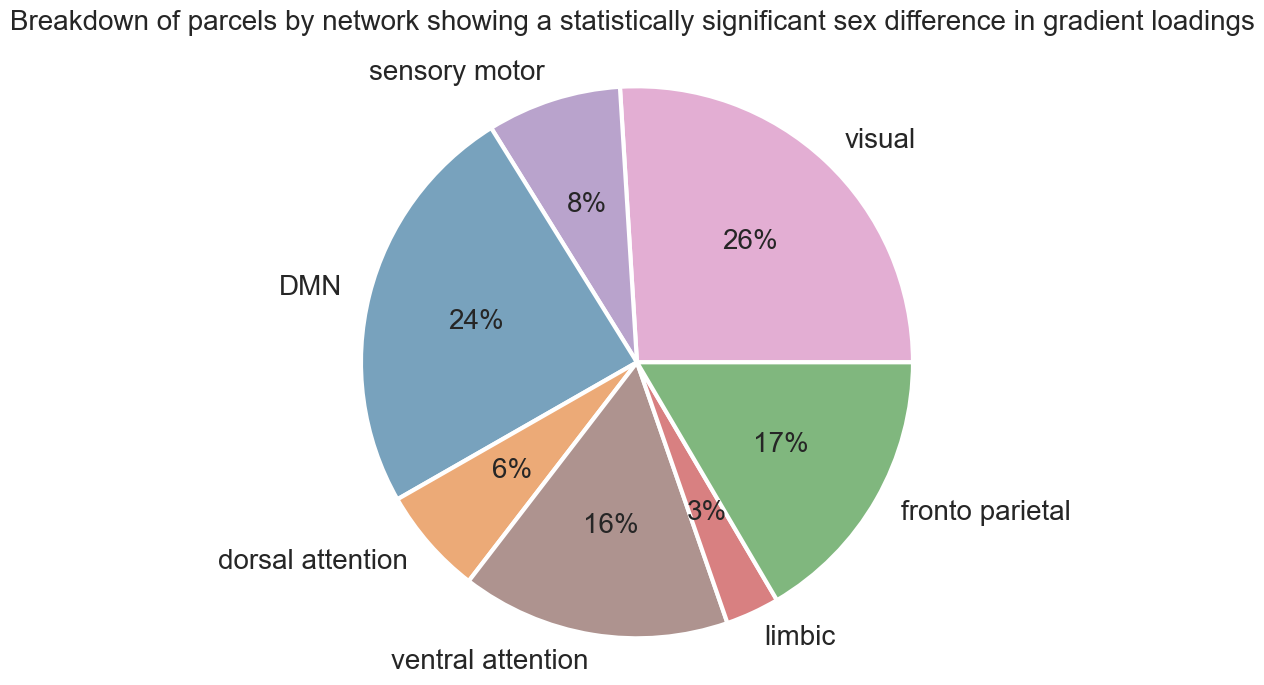

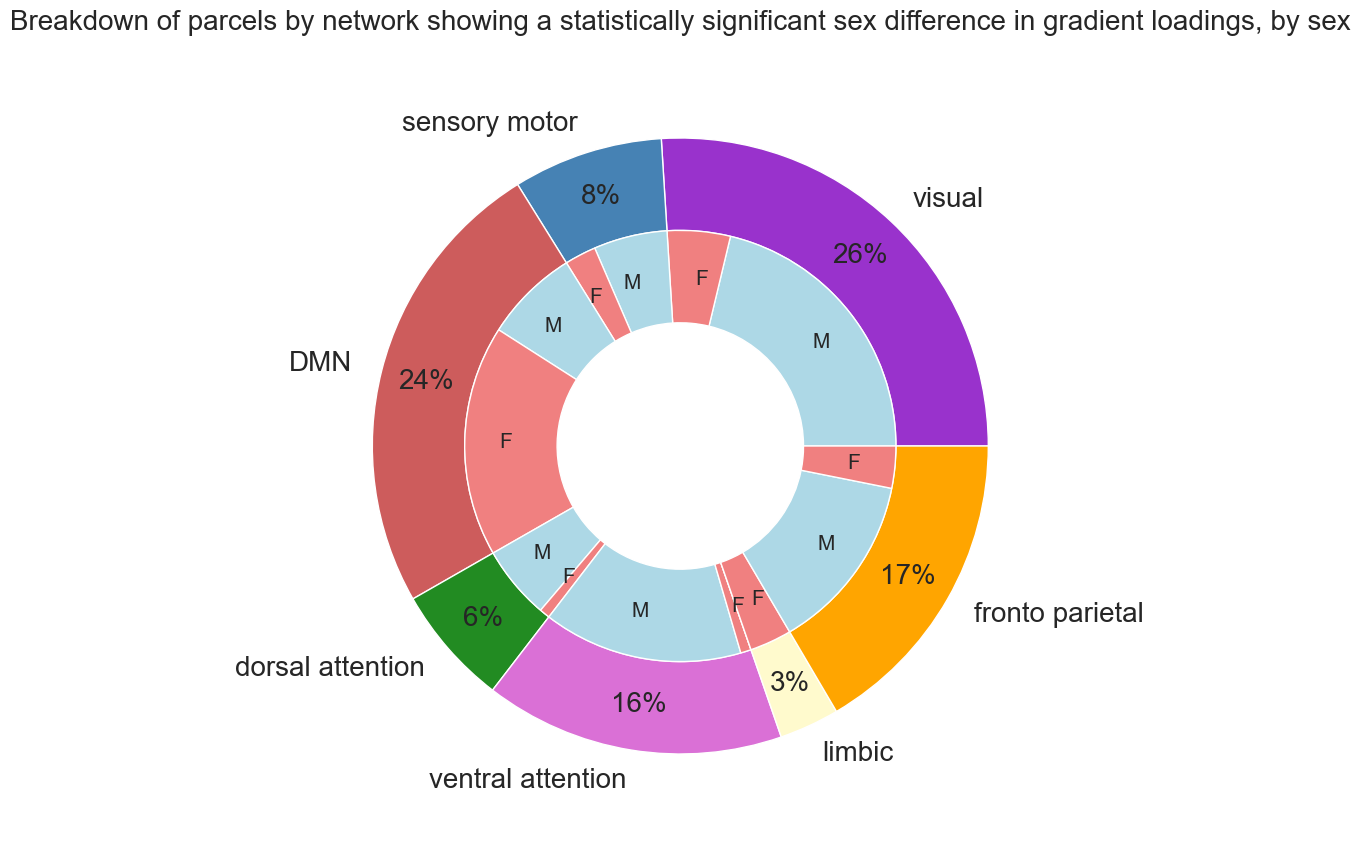

Number of significant parcels by sex:
visual - Male: 27, Female: 6
sensory motor - Male: 7, Female: 3
DMN - Male: 9, Female: 22
dorsal attention - Male: 7, Female: 1
ventral attention - Male: 19, Female: 1
limbic - Male: 0, Female: 4
fronto parietal - Male: 17, Female: 4





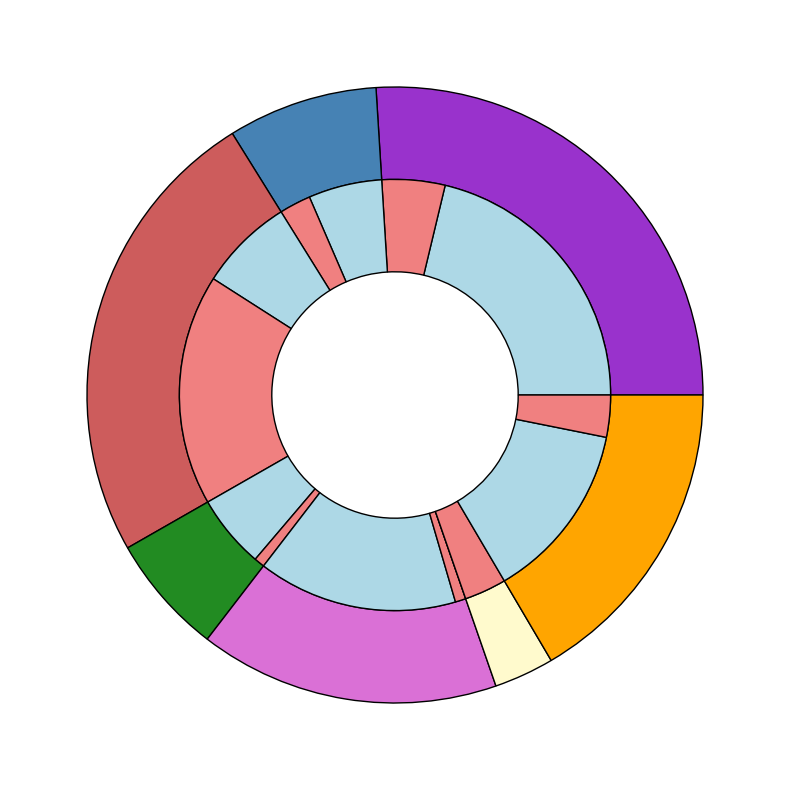




Violin plot of t-values (regression results) by Yeo network


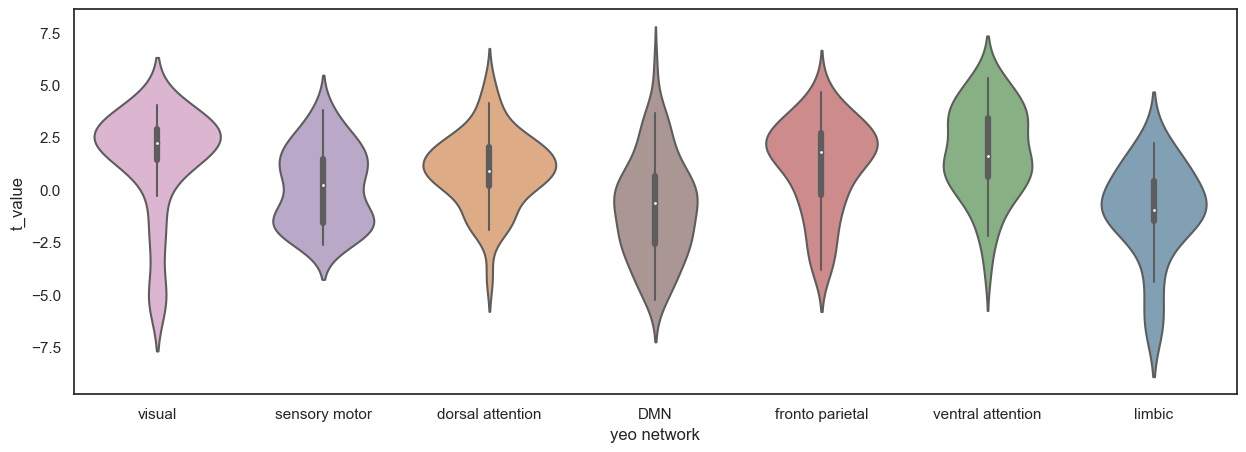

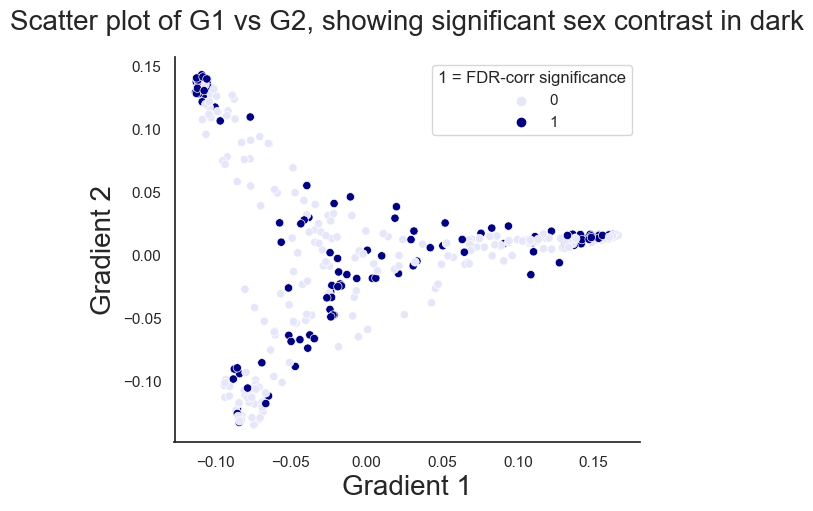

In [166]:
regression_contrast_results_breakdown_by_network(sextq_values_DM_adj, 'sex', 
                                                 scatter_x = gm_mean1_adjusted, scatter_y = gm_mean2_adjusted,
                                                 sample_modality = 'HCP_fc_G1_DM_Glasser',
                                                 scatter_x_label = 'Gradient 1',
                                                 scatter_y_label = 'Gradient 2',
                                                scatterplot = True)

In [121]:
networks_yeo_numpy

array([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,  2.,  3.,  3.,  2.,  1.,
         7.,  6.,  1.,  3.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,  4.,  7.,
         7.,  7.,  6.,  7.,  7.,  7.,  7.,  7.,  7.,  2.,  4.,  4.,  2.,
         2.,  2.,  3.,  4.,  4.,  3.,  3.,  3.,  3.,  3.,  3.,  2.,  2.,
         2.,  2.,  2.,  2.,  4.,  6.,  4.,  4.,  7.,  7.,  6.,  7.,  7.,
         7.,  7.,  7.,  7.,  7.,  7.,  7.,  6.,  6.,  7.,  7.,  7.,  4.,
         6.,  3.,  6.,  6.,  6.,  6.,  6.,  6.,  7.,  5.,  7.,  5.,  6.,
         5.,  5.,  7.,  3.,  3.,  6.,  7.,  4.,  2.,  2.,  2.,  2.,  2.,
         4.,  4.,  2.,  4.,  4., nan,  6.,  7.,  4.,  4.,  4.,  3.,  3.,
         5.,  1., nan,  1.,  5.,  7.,  2.,  7.,  1.,  1.,  7.,  7.,  7.,
         5.,  7.,  7.,  7.,  5.,  3.,  3.,  3.,  7.,  3.,  3.,  1.,  3.,
         6.,  6.,  3.,  4.,  4.,  6.,  7.,  7.,  1.,  1.,  1.,  7.,  1.,
         3.,  1.,  1.,  1.,  7.,  7.,  1.,  5.,  7.,  5.,  4.,  2.,  4.,
         7.,  6.,  5.,  2.,  2.,  2.,  7.,  7.,  4.